<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/08-object-detection/02_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Object detection

We’ll now
learn how a more involved approach, with multiple components working together, can perform bounding-box-based object detection. This strategy finds objects in one pass,
and a second step determines what specific object is present at a location.

We want the model to detect objects by drawing a box around any object of interest.
Since objects could be at weird sizes or angles, the goal is that the box should bound
the object, so the box should be just big enough to fit the entire object within the box.

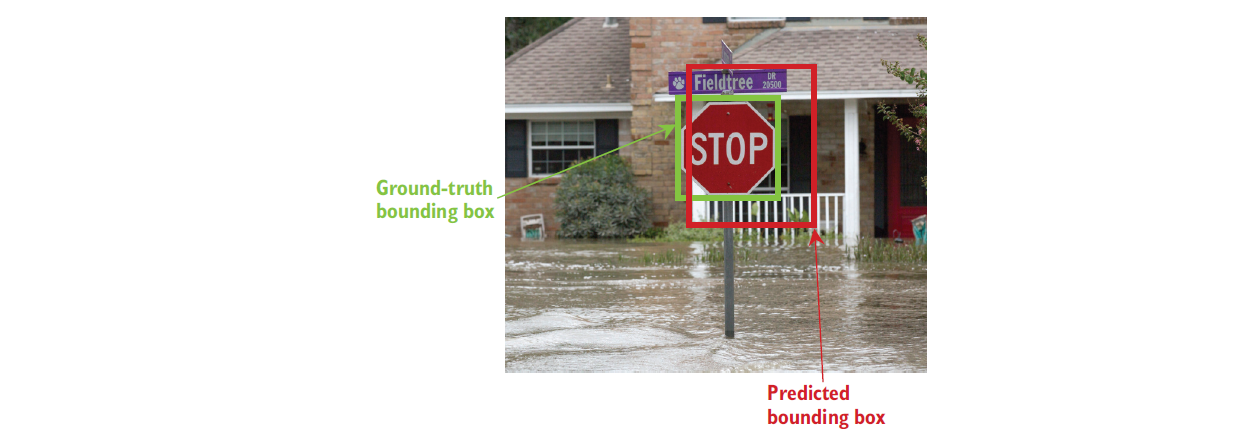

In particular, we go over an algorithm called Faster R-CNN,4 which has become the
de facto baseline for object detection.

The three steps we described can be broken into three subnetworks: 
* a backbone network to extract feature maps, 
* a region proposal network (RPN) to find objects,
* and a region of interest pooling (RoI pooling or just RoI) network that predicts what type of object is being looked at.

We will not implement Faster R-CNN from scratch because it has a number of
important details and takes hundreds of lines of code to implement in total.

If you want the minutia, check out the article **[Object Detection
and Classification using R-CNNs](https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/)**.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import set_seed
from idlmam import train_network, Flatten, View, weight_reset, moveTo

In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Our toy dataset will be a larger `100x100`
image containing a random number of
MNIST digits in random locations. The goal will be to detect where these images are and classify them correctly.

In [ ]:
class Class2Detect(Dataset):
  """
  This class is used to create a simple converstion of a dataset from a classification problem, to a detection problem.
  """
  def __init__(self, dataset, toSample=3, canvas_size=100):
    """
    dataset: the source dataset to sample items from as the "objects" to detect
    toSample: the maximum number of "objects" to put into any image
    canvas_size: the width and height of the images to place objects inside of.
    """
    self.dataset = dataset
    self.toSample = toSample 
    self.canvas_size = canvas_size 

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    boxes = []
    labels = []
    final_size = self.canvas_size

    # First, create a larger image that will store all the "objects" to detect
    img_path = torch.zeros((final_size, final_size), dtype=torch.float32)
    
    # Now we are going to sample up to self.toSample objects to place into the image
    for _ in range(np.random.randint(1, self.toSample + 1)):
      # Pick an object at random from the original dataset, and its label
      img, label = self.dataset[np.random.randint(0, len(self.dataset))]
      # Get the height and width of that image
      _, img_h, img_w = img.shape
      # Pick a random offset of the x and y axis, essentially placing the image at a random location
      offsets = np.random.randint(0, final_size - np.max(img.shape), size=(4))
      # Change the padding at the end to make sure we come out to a specific 100,100 shape
      offsets[1] = final_size - img.shape[1] - offsets[0]
      offsets[3] = final_size - img.shape[2] - offsets[2]

      with torch.no_grad():
        img_path = img_path + F.pad(img, tuple(offsets))

      # Lets craete the values for the "boxes", all of these are in absolute pixel locations
      # x_min determined by the randomly selected offset
      xmin = offsets[0]
      # x_max is the offset plus the image's width
      xmax = offsets[0] + img_w
      # y min/max follows the same pattern
      ymin = offsets[2]
      ymax = offsets[2] + img_h
      # now we add to the box with the right label
      boxes.append([xmin, ymin, xmax, ymax])
      labels.append(label)

    target = {}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
    
    return img_path, target

Now that we can load the dataset.

In [ ]:
train_data = Class2Detect(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data = Class2Detect(torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True))

Faster R-CNN is designed to work with images of highly variable size, so we would not have the same W and H values for every item. 

Instead, Faster R-CNN
wants a list of tensors and a list of dictionaries. We have to use a custom collate
function to make that happen.

In [ ]:
def collate_fn(batch):
  """
  batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
  The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. 
  So we will use this function to convert the batch of data into the form we want, and then give it to the Dataloader to use
  """
  imgs = []
  labels = []
  for img, label in batch:
    imgs.append(img)
    labels.append(label)
  return imgs, labels

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)

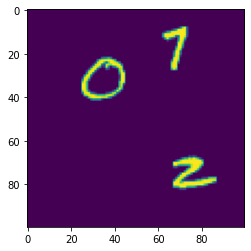

In [ ]:
# Grab an image with its labels
x, y = train_data[0]

imshow(x.numpy()[0, :])

In [ ]:
# Let’s look at the label object, y.
print(y)

# prints a tensor showing the pixel locations of the corners for all 3 objects
print(f"Boxes: {y['boxes']}")
# prints a tensor showing the labels for all 3 objects
print(f"Labels: {y['labels']}")

{'boxes': tensor([[61., 61., 89., 89.],
        [54.,  2., 82., 30.],
        [20., 17., 48., 45.]]), 'labels': tensor([2, 7, 0])}
Boxes: tensor([[61., 61., 89., 89.],
        [54.,  2., 82., 30.],
        [20., 17., 48., 45.]])
Labels: tensor([2, 7, 0])


##Faster R-CNN Model

Let's define some parameters.

In [ ]:
C = 1           # How many channels are in the input?
classes = 10    # How many classes are there? 
n_filters = 32  # How many filters in our backbone

Let's build a small backbone network to use.

In [ ]:
backbone = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters, n_filters),
  cnn_layer(n_filters, n_filters),
  nn.MaxPool2d((2, 2)),

  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters, 2 * n_filters),
  nn.MaxPool2d((2, 2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters, 4 * n_filters),
)

# Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters * 4

Now we can define our Faster R-CNN model. We give it the backbone network and
tell it how many classes exist and how to normalize the image.

We also tell Faster R-CNN the minimum and maximum image sizes.

In [ ]:
# How many proposals $k$ should be generated? 
# Every aspect ration will be one, and the process will be repeated for multiple image sizes 
# To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size
anchor_generator = AnchorGenerator(sizes=((32), ), aspect_ratios=((1.0), )) 

# Tell PyTorch to use the final output of the backbone as the featuremap (['0']), 
# use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)

# Now we can create the FasterRCNN object. We give it the backbone network, number of classes, 
# min & max size to process images at (we know all our images at 100 pixels), 
# a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone, 
                   num_classes=10,
                   image_mean=[0.5],
                   image_std=[0.229],
                   min_size=100,
                   max_size=100,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Let's implement Faster R-CNN training loop.

In [ ]:
model = model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
  running_loss = 0.0
  for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
    # Move the batch to the device we are using
    inputs = moveTo(inputs, device)
    labels = moveTo(labels, device)

    optimizer.zero_grad()

    # rcnn wants model(inputs, labels) - not just model(inputs)
    losses = model(inputs, labels)

    # Compute loss, RCNN gives us a list of losses to add up.
    loss = 0
    for partial_loss in losses.values():
      loss += partial_loss
    
    # now proceed like normal
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

Now let’s see how well it did.

In [ ]:
model = model.eval()
model.to(device)

Next, let’s quickly grab an item from the test dataset and see what it looks like.

In [ ]:
set_seed(161)

x, y = test_data[0]
# the ideal truth we want to get back
print(y)

Let’s make a prediction.

In [ ]:
with torch.no_grad():
  pred = model([x.to(device)])
print(pred)

And now we can look at our results.